In [1]:
import os
import numpy as np
import time
import json
import shutil

import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from src import data_loader

import matplotlib.pyplot as plt

In [13]:

class_color_maps = {'0': (0, 0, 0), # background -> black
 '1': (234, 155, 162),
 '2': (211, 78, 67),
 '3': (237, 231, 159),
 '4': (145, 209, 61),
 '5': (137, 193, 198),
 '6': (27, 230, 195),
 '7': (52, 138, 174),
 '8': (216, 86, 141),
 '9': (243, 157, 207),
 '10': (118, 176, 70),
 '11': (238, 173, 77),
 '12': (205, 219, 90),
 '13': (43, 56, 153)}



# Define the number of classes
num_classes = len(class_color_maps)

# Define a function to annotate the classes in the ground truth
def annotate_classes(mask):
    # Create an output image with the same shape as the input mask
    h, w = mask.shape[:2]
    output = np.zeros((h, w, 3), dtype=np.uint8)

    for class_, color in class_color_maps.items():
        output[mask == int(class_)] = color

    return output

def show_imgs(x,y,y_pred):
    n = x.shape[0]
    
    fig, ax = plt.subplots(n, 3, figsize=(3*5, n*5))

    for i, (img, mask, mask_pred) in enumerate(zip(x,y,y_pred)):
        
        ax[i][0].imshow(img.permute(1,2,0).detach().cpu())
        ax[i][1].imshow(annotate_classes(mask.detach().cpu()))

        mask_pred = mask_pred.permute(1,2,0).detach().cpu().numpy()
        mask_pred = np.argmax(mask_pred, axis=2)
        
        ax[i][2].imshow(annotate_classes(mask_pred))


In [16]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

args = {
   "train_dir": "./data/",
   "lr": 0.1,
   "epochs": 10,
   "validation_split": 0.2,
   "batch_size": 4,
   "encoder": "resnet18",
   "debug": True,
   "checkpoints_dir": "./checkpoints/",
   "continue_epoch": 0,
   "loss": "ce"
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0 | train_loss: 1.9373230934143066 | val_loss: 671163584.0 | time: 2.249s
model .pth and smp configs at epoch 0 saved!



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1 | train_loss: 1.808093547821045 | val_loss: 1667405.875 | time: 3.244s
model .pth and smp configs at epoch 1 saved!



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

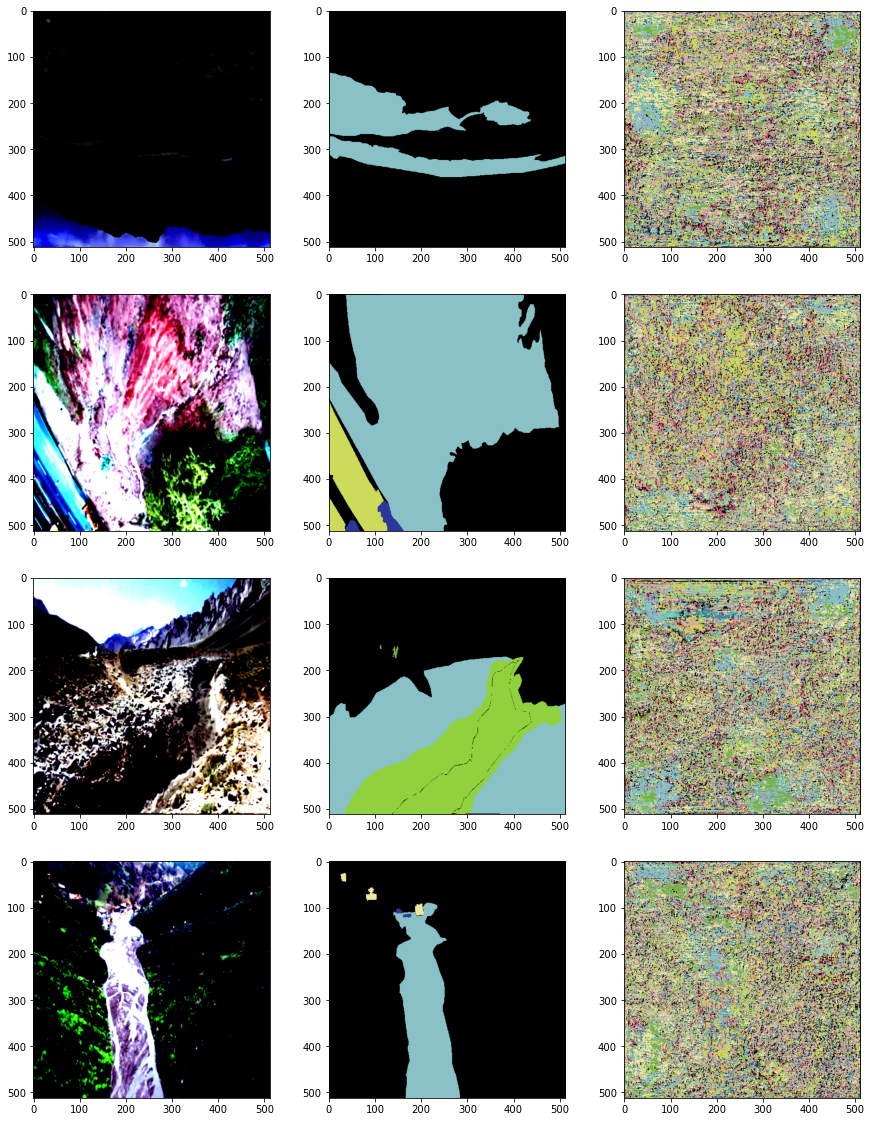

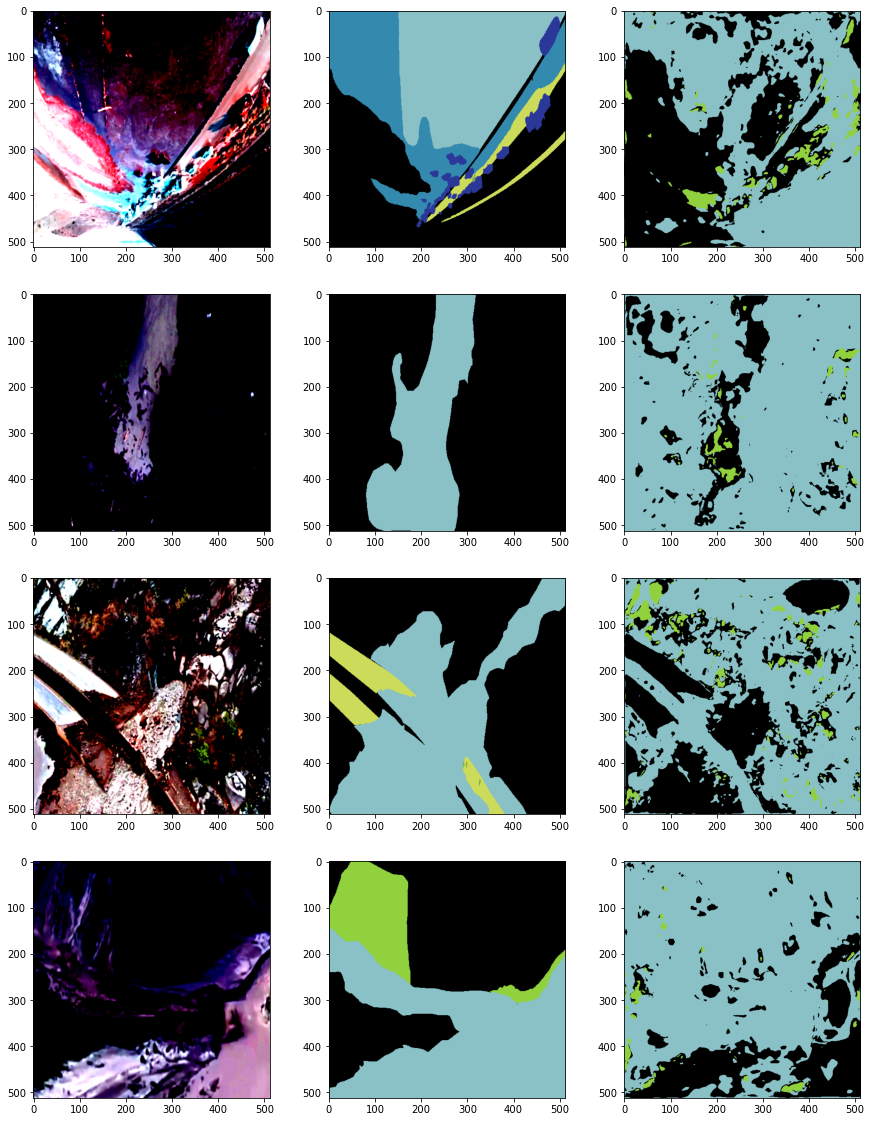

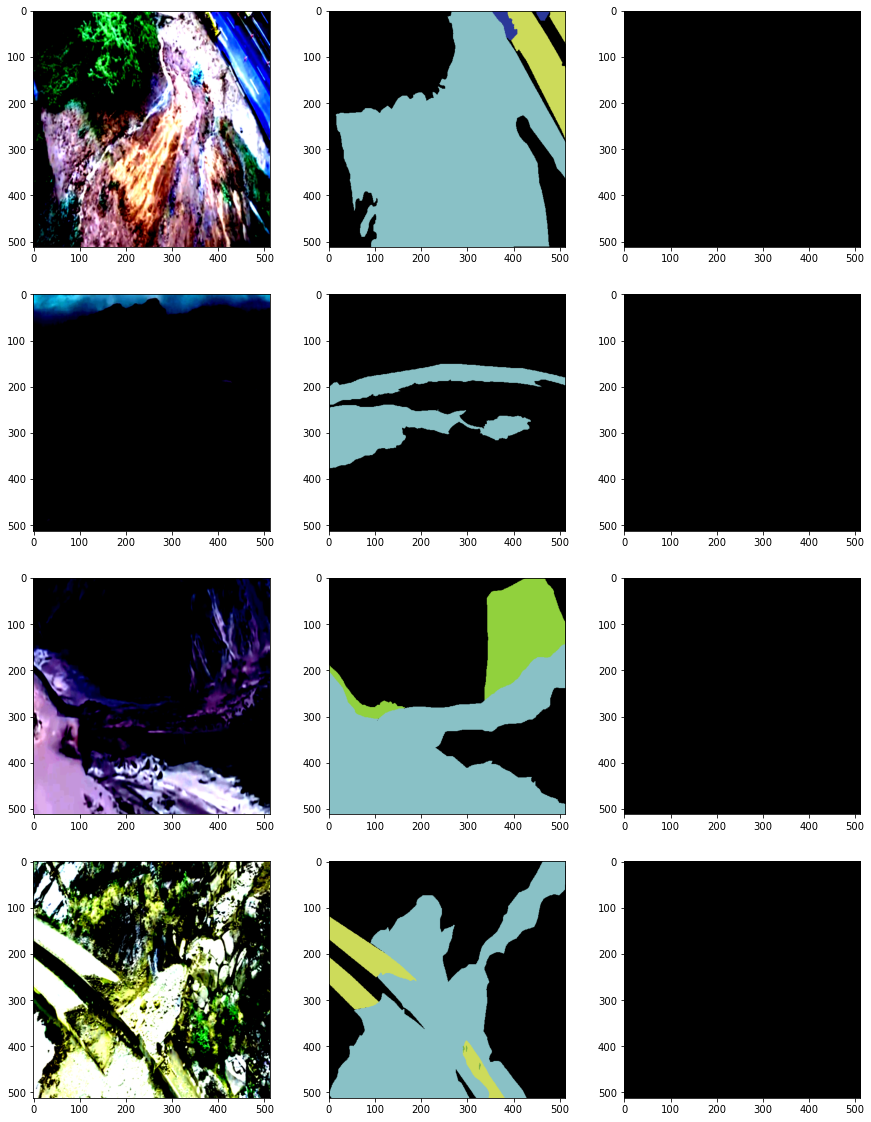

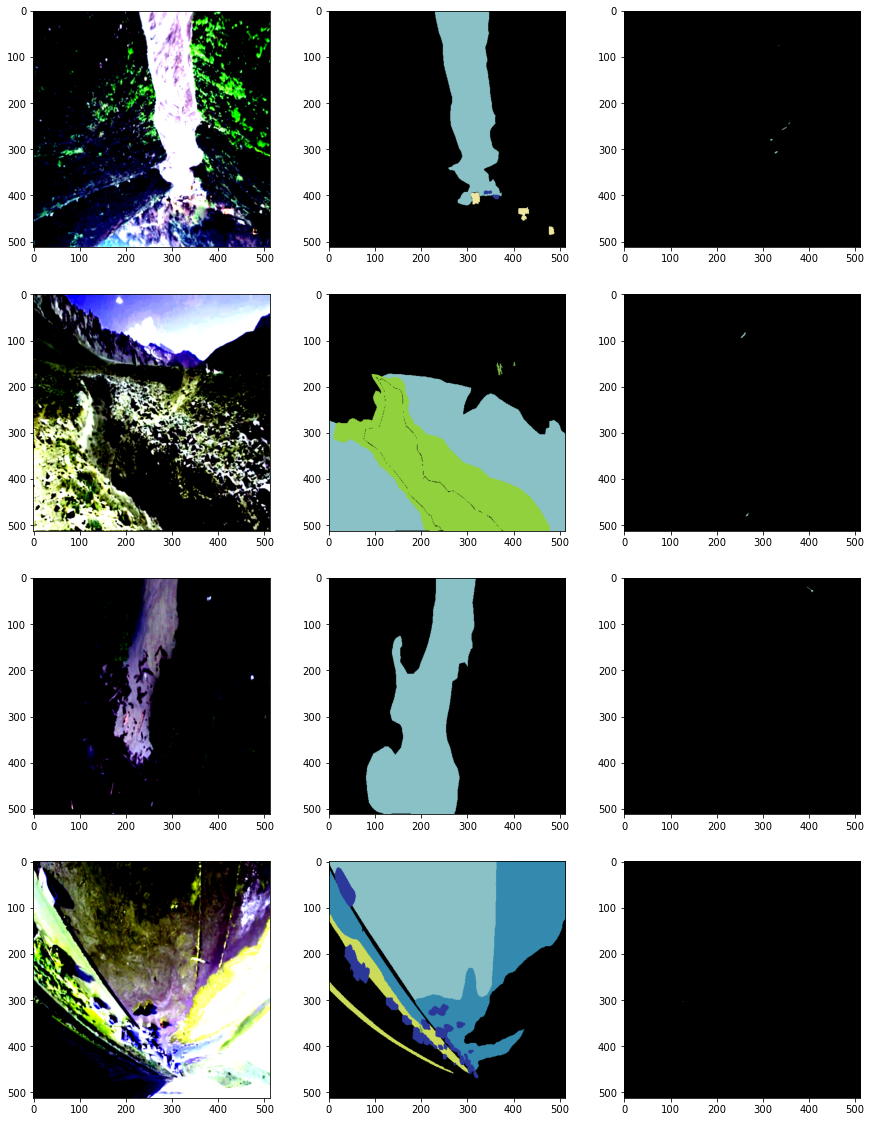

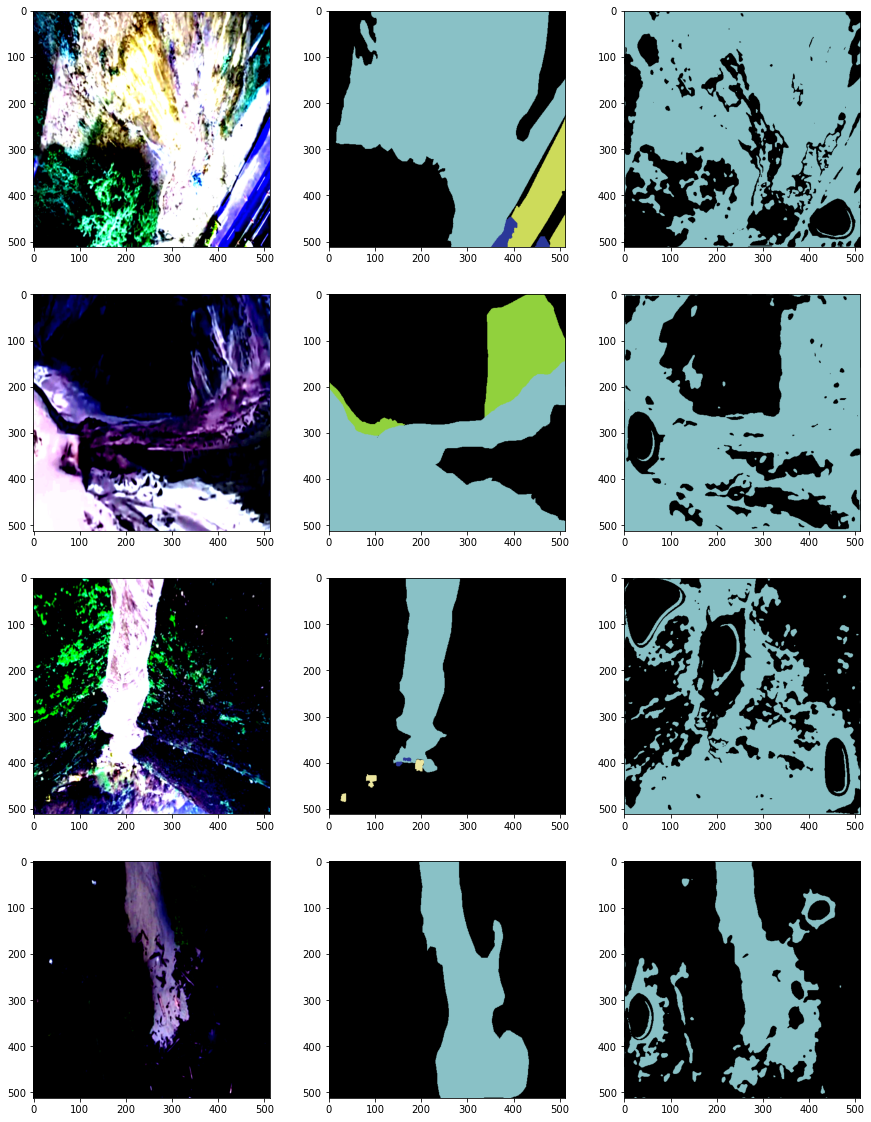

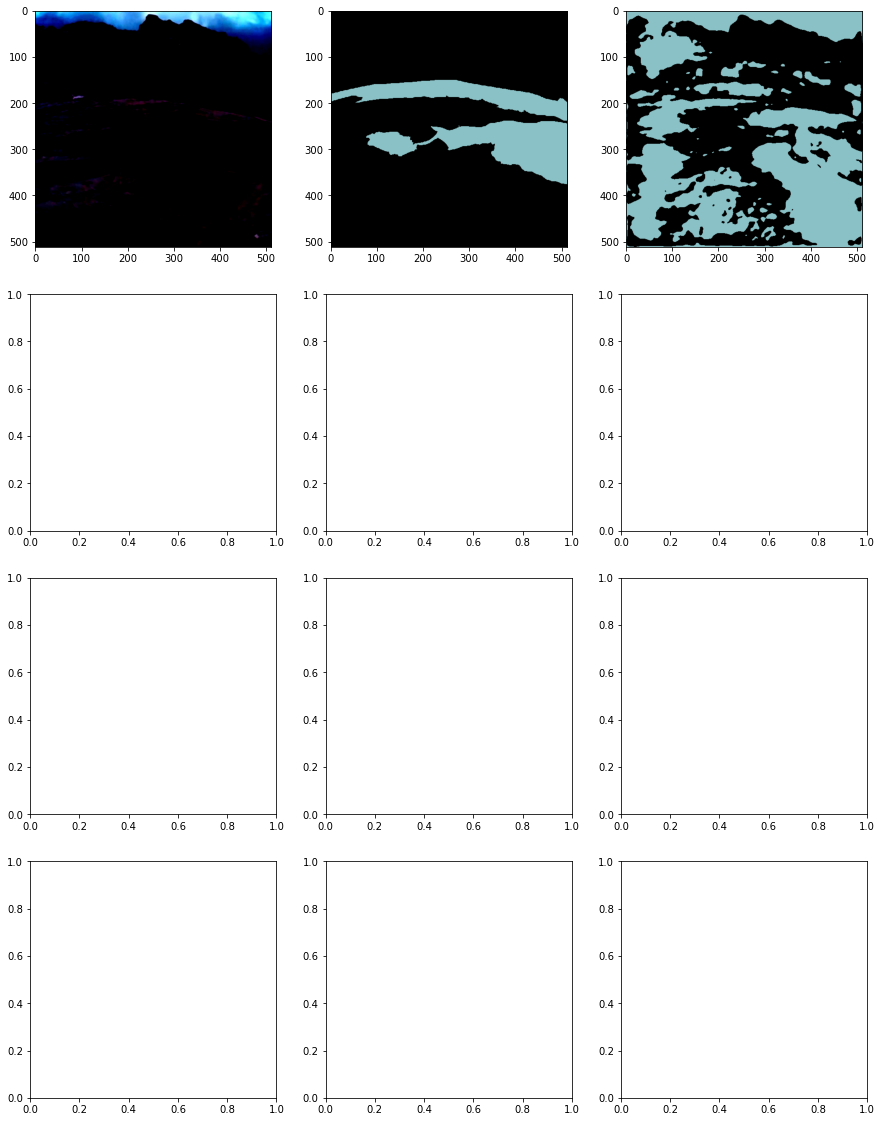

In [18]:
if args['loss'] == 'focal':
    loss_ = smp.losses.FocalLoss(mode='multiclass', gamma=3/4)
elif args['loss'] == 'dice':
    loss_ = smp.losses.DiceLoss(mode='multiclass')
elif args['loss'] == 'ce':
    loss_ = nn.CrossEntropyLoss()
else:
    raise Exception('Loss is not valid.')


train_dl, val_dl = data_loader.get_train_data_loaders(args['train_dir'], args['validation_split'], args['batch_size'])

if args['continue_epoch'] != 0:
    model_path = os.path.join(args['checkpoints_dir'], f"checkpoint_{args['continue_epoch']}", 'model.pth')
    smp_configs_path = os.path.join(args['checkpoints_dir'], f"checkpoint_{args['continue_epoch']}", 'smp_configs.json')

    with open(smp_configs_path, 'r') as f:
        smp_configs = json.load(f)

    model = smp.Unet(
        encoder_name=smp_configs['encoder'],
        encoder_weights='imagenet',
        in_channels=3,
        classes=14
    )

    if os.path.exists(model_path):
        model.load_state_dict(
            torch.load(
                model_path
            )
        )
        print(f"model loaded from save checkpoint at epoch {args['continue_epoch']}")
    else:
        print(f"can't fine the loaded model checkpoint at epoch {args['continue_epoch']} at {model_path}")

else:
    model = smp.Unet(
        encoder_name=args['encoder'],
        encoder_weights='imagenet',
        in_channels=3,
        classes=14
    )

opt = torch.optim.Adam(model.parameters(), lr=args['lr'])
# freezing encoder's weights
for param in model.encoder.parameters():
    param.requires_grad = False

model.to(device)

train_losses = []
val_losses = []

for ep in range(args['epochs']):
    train_loss = 0
    t1 = time.time()

    model.train()

    train_dl.dataset.dataset.phase = 'train'
    for (x,y) in train_dl:
        x = x.to(device)

        y_pred = model(x)
        y = y.to(device)

        opt.zero_grad()
        loss_i = loss_(y_pred, y)

        loss_i.backward()
        opt.step()

        train_loss += loss_i.item()

        if args['debug']:
            show_imgs(x,y,y_pred)
    
    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    val_loss = 0
    val_dl.dataset.dataset.phase = 'val'
    model.eval()
    with torch.no_grad():
        for (x,y) in val_dl:
            x = x.to(device)

            y_pred = model(x)
            y = y.to(device)

            val_loss += loss_(y_pred, y).item()
        
        val_loss /= len(val_dl)
        val_losses.append(val_loss)

    print('epoch: {epoch} | train_loss: {loss} | val_loss: {val_loss} | time: {time:.3f}s'.format(epoch=ep+1, loss=loss_i, time=time.time() - t1, val_loss=val_loss))

    # save checkpoint
    checkpoint_dir = os.path.join(args['checkpoints_dir'], f'checkpoint_{ep}')
    shutil.rmtree(checkpoint_dir, ignore_errors=True)
    os.mkdir(checkpoint_dir)
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'model.pth'))
    with open(os.path.join(checkpoint_dir, 'smp_configs.json'), 'w') as f:
        json.dump({
            "encoder": args['encoder']
        }, f)

    print(f'model .pth and smp configs at epoch {ep} saved!')
    print()


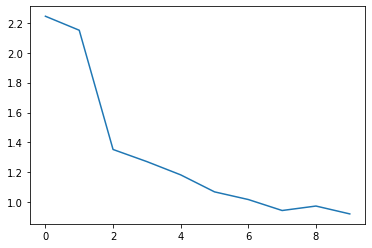

In [ ]:
plt.plot(train_losses)

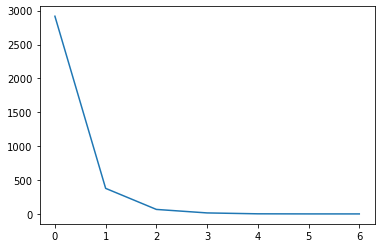

In [ ]:
plt.plot(val_losses[3:])